Note: you may need to restart the kernel to use updated packages.
[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)


You are using pip version 8.1.1, however version 20.2.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


LR: 0.500906 (0.051219)
LDA: 0.448534 (0.031931)
KNN: 0.357044 (0.025681)
CART: 0.481214 (0.034663)
RF: 0.640457 (0.024562)
NB: 0.362735 (0.029703)
SVM: 0.043343 (0.027239)


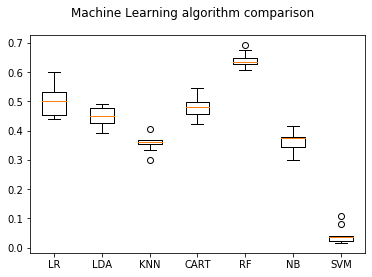

NameError: name 'mahotas' is not defined

In [2]:
%pip install mahotas
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
fixed_size       = tuple((500, 500))
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature)

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
pip install mahotas

Note: you may need to restart the kernel to use updated packages.


You are using pip version 8.1.1, however version 20.2.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
